In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import transform

import glob
import cv2
from PIL import Image
import numpy as np

### Data Loader

In [2]:
image_dim = (128, 128, 3)
image_dir = './datasets/monet2photo/'

In [3]:
len(tf.config.list_physical_devices('GPU')) > 0

True

In [4]:
# taken from https://github.com/mehulgupta2016154/GANs/blob/main/cyclegan/cycleGANs.ipynb

def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images

def tf_pipeline(dataset):
    dataset = tf.data.Dataset.from_tensor_slices({'image':dataset})
    dataset = dataset.map(preprocess)
    dataset = dataset.repeat().shuffle(100).batch(16).prefetch(1)
    return dataset
    
def tf_data(path):
    trainingA = []
    for x in glob.glob(path+'A/*'):
        image = Image.open(x)
        image = image.resize((128,128))
        trainingA.append(np.array(image))
        
    trainingB = []
    for x in glob.glob(path+'B/*'):
        image = Image.open(x)
        image = image.resize((128,128))
        trainingB.append(np.array(image))
    a,b = tf_pipeline(trainingA),tf_pipeline(trainingB)
    return a,b

trainA,trainB = tf_data(image_dir+'train')
trainA = trainA.__iter__()
trainB = trainB.__iter__()

In [5]:
steps = 94

### Architecture

In [6]:
# The blocks

def convolutions(input_layer, filter_numbers, kernel_size, padding, strides, activation='relu'):
    x_c = tf.keras.layers.Conv2D(filter_numbers, kernel_size=kernel_size, padding=padding, strides=strides)(input_layer) 
    x_c = tfa.layers.InstanceNormalization()(x_c)
    x_c = tf.keras.layers.Activation(activation)(x_c)
    return x_c

def resnet(input_layer, filter_numbers, kernel_size, strides):
    x_r = tf.keras.layers.Conv2D(filter_numbers, kernel_size, padding='same', strides=strides)(input_layer)
    x_r = tfa.layers.InstanceNormalization()(x_r)
    x_r = tf.keras.layers.Activation('relu')(x_r)
    
    x_r = tf.keras.layers.Conv2D(filter_numbers, kernel_size, padding='same', strides=strides)(x_r)
    x_r = tfa.layers.InstanceNormalization()(x_r)
    
    x_r3 = tf.keras.layers.add([input_layer, x_r])
    x_r3 = tf.keras.layers.Activation('relu')(x_r3)
    return x_r3

def up_sample(input_layer, filter_numbers, kernel_size, padding, strides, activation='relu'):
    x_u = tf.keras.layers.UpSampling2D((2, 2))(input_layer)
    x_u = tf.keras.layers.Conv2D(filter_numbers, kernel_size=kernel_size, padding=padding, strides=strides)(x_u) 
    x_u = tfa.layers.InstanceNormalization()(x_u)
    x_u = tf.keras.layers.Activation(activation)(x_u)
    return x_u

def conv_transpose(input_layer, filter_numbers, kernel_size, padding, strides, activation='relu'):
    x_t = tf.keras.layers.Conv2DTranspose(filter_numbers, kernel_size=kernel_size, padding=padding, strides=strides)(input_layer)
    x_t = tfa.layers.InstanceNormalization()(x_t)
    x_t = tf.keras.layers.Activation(activation)(x_t)
    return x_t

In [7]:
# The generator
def generator(input_layer, resnet_number):
    
    # filters=64, kernel=7x7, strides=1
    x_g = convolutions(input_layer=input_layer, filter_numbers=64, kernel_size=(7, 7), padding='same', strides=1) 
    
    # filters=128, kernel=3x3, strides=2
    x_g = convolutions(input_layer=x_g, filter_numbers=128, kernel_size=(3, 3), padding='same', strides=2) 
    
    # filters=256, kernel=3x3, strides=2
    x_g = convolutions(input_layer=x_g, filter_numbers=256, kernel_size=(3, 3), padding='same', strides=2) 
    
    # Resnet Blocks
    for i in range(resnet_number):
        x_g = resnet(x_g, filter_numbers=256, kernel_size=(3,3), strides=1)
        
    # Transpose Blocks for UpSampling
    x_g = conv_transpose(input_layer=x_g, filter_numbers=128, kernel_size=(3,3), padding='same', strides=2)
    x_g = conv_transpose(input_layer=x_g, filter_numbers=64, kernel_size=(3,3), padding='same', strides=2)
    x_g = conv_transpose(input_layer=x_g, filter_numbers=3, kernel_size=(7,7), padding='same', strides=1, activation='tanh')
    
    model = tf.keras.Model(input_layer, x_g)
    return model

In [8]:
# The discriminator

def discriminator(input_layer):
    # 70x70 patch GAN
    x_d = convolutions(input_layer=input_layer, filter_numbers=64, kernel_size=(4, 4), padding='same', strides=2, activation=tf.nn.leaky_relu)
    x_d = convolutions(input_layer=x_d, filter_numbers=128, kernel_size=(4, 4), padding='same', strides=2, activation=tf.nn.leaky_relu) 
    x_d = convolutions(input_layer=x_d, filter_numbers=256, kernel_size=(4, 4), padding='same', strides=2, activation=tf.nn.leaky_relu)
    x_d = convolutions(input_layer=x_d, filter_numbers=512, kernel_size=(4, 4), padding='same', strides=2, activation=tf.nn.leaky_relu)
    x_d = convolutions(input_layer=x_d, filter_numbers=1, kernel_size=(4, 4), padding='same', strides=1, activation='sigmoid')
    
    model = tf.keras.Model(input_layer, x_d)
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam())
    return model

In [9]:
# Overall Model

def overall_model(genAB, genBA, dis):
    genAB.trainable = True
    dis.trainable = False
    genBA.trainable = False
    
    x_a = tf.keras.layers.Input(shape=image_dim)
    x_b = tf.keras.layers.Input(shape=image_dim) # for identity
    x_b_dis = tf.keras.layers.Input(shape=image_dim)
    
    # Adversarial loss
    genAB_out = genAB(x_a)
    dis_out = dis(genAB_out)
    
    # Identity loss
    genBB_out = genAB(x_b)
    
    # Forward loss
    genFL = genBA(genAB_out)
    
    # Backward loss
    genBA_out = genBA(x_b)
    genBL = genAB(genBA_out)
    
    model = tf.keras.Model([x_a, x_b], [dis_out, genBB_out, genFL, genBL])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=tf.keras.optimizers.Adam())
    return model
    

x_a = tf.keras.layers.Input(shape=image_dim)
x_b = tf.keras.layers.Input(shape=image_dim) # for identity
x_disA = tf.keras.layers.Input(shape=image_dim)
x_disB = tf.keras.layers.Input(shape=image_dim)
    
    
genAB = generator(x_a,6)
genBA = generator(x_b,6)
dis_A = discriminator(x_disA)
dis_B = discriminator(x_disB)

In [10]:
model_ovrAB = overall_model(genAB, genBA, dis_B)
model_ovrAB.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  7845129     ['input_5[0][0]',                
                                                                  'input_6[0][0]',                
                                                                  'model_1[1][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                         

In [11]:
model_ovrBA = overall_model(genBA, genAB, dis_A)
model_ovrBA.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 128, 128, 3)  7845129     ['input_8[0][0]',                
                                                                  'input_9[0][0]',                
                                                                  'model[4][0]']                  
                                                                                                  
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                         

In [12]:
def generate_real(dataset, batch_size,patch_size):
    labels = np.ones((batch_size,patch_size,patch_size,1))
    return dataset,labels

def generate_fake(dataset,g,batch_size,patch_size):
    predicted = g(dataset)
    labels = np.zeros((batch_size,patch_size,patch_size,1))
    return predicted,labels

#### Training

In [13]:
import os
checkpoint_dir = './cyclegan'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generatorAB=genAB, generatorBA=genBA,discriminator_A=dis_A, discriminator_B = dis_B,overall_modelAB = model_ovrAB, overall_modelBA = model_ovrBA)
manager = tf.train.CheckpointManager(checkpoint, 'cyclegan', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)

In [21]:
manager.latest_checkpoint

'cyclegan\\ckpt-1896'

In [22]:
def train(discriminator_A, discriminator_B, generatorAB, generatorBA, overall_modelAB, overall_modelBA, epochs, batch_size, steps):
    n_patch = discriminator_A.output_shape[1]
    
    for epoch in range(1,epochs):
        for step in range(1,steps):
            print(epoch,step)
            
            x_real_A, y_real_A = generate_real(next(trainA),batch_size,n_patch)
            x_real_B, y_real_B = generate_real(next(trainB),batch_size,n_patch)
            
            x_fake_A, y_fake_A = generate_fake(x_real_B, generatorBA,batch_size,n_patch)
            x_fake_B, y_fake_B = generate_fake(x_real_A, generatorAB,batch_size,n_patch)
            
            g_A_B_loss,_,_,_,_ = overall_modelAB.train_on_batch([x_real_A,x_real_B],[y_real_B,x_real_B, x_real_A, x_real_B])
            disc_A_real_loss = discriminator_A.train_on_batch(x_real_A, y_real_A)
            disc_A_fake_loss = discriminator_A.train_on_batch(x_fake_A, y_fake_A)
            
            g_B_A_loss,_,_,_,_ = overall_modelBA.train_on_batch([x_real_B,x_real_A],[y_real_A,x_real_A, x_real_B, x_real_A])
            disc_B_real_loss = discriminator_B.train_on_batch(x_real_B, y_real_B)
            disc_B_fake_loss = discriminator_B.train_on_batch(x_fake_B, y_fake_B)
            
            print('g_A_B_loss',g_A_B_loss)
            print('g_B_A_loss',g_B_A_loss)
            
            manager.save()

In [23]:
train(dis_A, dis_B, genAB, genBA, model_ovrAB, model_ovrBA, epochs=10, batch_size=16, steps=94)

1 1
g_A_B_loss 3.18845272064209
g_B_A_loss 3.0289275646209717
1 2
g_A_B_loss 2.8649535179138184
g_B_A_loss 2.8680663108825684
1 3
g_A_B_loss 3.0779194831848145
g_B_A_loss 2.922410249710083
1 4
g_A_B_loss 3.558809280395508
g_B_A_loss 3.3677327632904053
1 5
g_A_B_loss 3.058295249938965
g_B_A_loss 2.927363872528076
1 6
g_A_B_loss 3.065796375274658
g_B_A_loss 2.897686004638672
1 7
g_A_B_loss 3.023449659347534
g_B_A_loss 2.8414664268493652
1 8
g_A_B_loss 3.342750072479248
g_B_A_loss 3.1214852333068848
1 9
g_A_B_loss 2.799299716949463
g_B_A_loss 2.7158141136169434
1 10
g_A_B_loss 3.071547746658325
g_B_A_loss 2.975987195968628
1 11
g_A_B_loss 3.0449118614196777
g_B_A_loss 3.012610912322998
1 12
g_A_B_loss 3.331620454788208
g_B_A_loss 3.036799430847168
1 13
g_A_B_loss 2.7921431064605713
g_B_A_loss 2.782871723175049
1 14
g_A_B_loss 2.734433174133301
g_B_A_loss 2.7503557205200195
1 15
g_A_B_loss 3.092653274536133
g_B_A_loss 3.0015487670898438
1 16
g_A_B_loss 3.0313568115234375
g_B_A_loss 2.88255

KeyboardInterrupt: 

### After Training

In [33]:
manager.checkpoints

['cyclegan\\ckpt-1413',
 'cyclegan\\ckpt-1414',
 'cyclegan\\ckpt-1415',
 'cyclegan\\ckpt-1416',
 'cyclegan\\ckpt-1417']

#### Evaluate

In [16]:
genNew = generator(x_a, 6)
genNew.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_46 (Ins  (None, 128, 128, 64  128        ['conv2d_40[0][0]']              
 tanceNormalization)            )                                                           

                                                                  'instance_normalization_54[0][0]
                                                                 ']                               
                                                                                                  
 activation_54 (Activation)     (None, 32, 32, 256)  0           ['add_14[0][0]']                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 32, 32, 256)  590080      ['activation_54[0][0]']          
                                                                                                  
 instance_normalization_55 (Ins  (None, 32, 32, 256)  512        ['conv2d_49[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 activatio

 instance_normalization_63 (Ins  (None, 128, 128, 3)  6          ['conv2d_transpose_8[0][0]']     
 tanceNormalization)                                                                              
                                                                                                  
 activation_63 (Activation)     (None, 128, 128, 3)  0           ['instance_normalization_63[0][0]
                                                                 ']                               
                                                                                                  
Total params: 7,845,129
Trainable params: 7,845,129
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
# load from checkpoint
checkpoint = tf.train.Checkpoint(generatorAB=genAB, generatorBA=genBA,discriminator_A=dis_A, discriminator_B = dis_B,overall_modelAB = model_ovrAB, overall_modelBA = model_ovrBA)
checkpoint.restore(manager.latest_checkpoint)
genNew = checkpoint.generatorAB
genNew.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization (Instan  (None, 128, 128, 64  128        ['conv2d[0][0]']                 
 ceNormalization)               )                                                             

                                                                  'instance_normalization_8[0][0]'
                                                                 ]                                
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 256)  590080      ['activation_8[0][0]']           
                                                                                                  
 instance_normalization_9 (Inst  (None, 32, 32, 256)  512        ['conv2d_9[0][0]']               
 anceNormalization)                                                                               
                                                                                                  
 activatio

 instance_normalization_17 (Ins  (None, 128, 128, 3)  6          ['conv2d_transpose_2[0][0]']     
 tanceNormalization)                                                                              
                                                                                                  
 activation_17 (Activation)     (None, 128, 128, 3)  0           ['instance_normalization_17[0][0]
                                                                 ']                               
                                                                                                  
Total params: 7,845,129
Trainable params: 0
Non-trainable params: 7,845,129
__________________________________________________________________________________________________


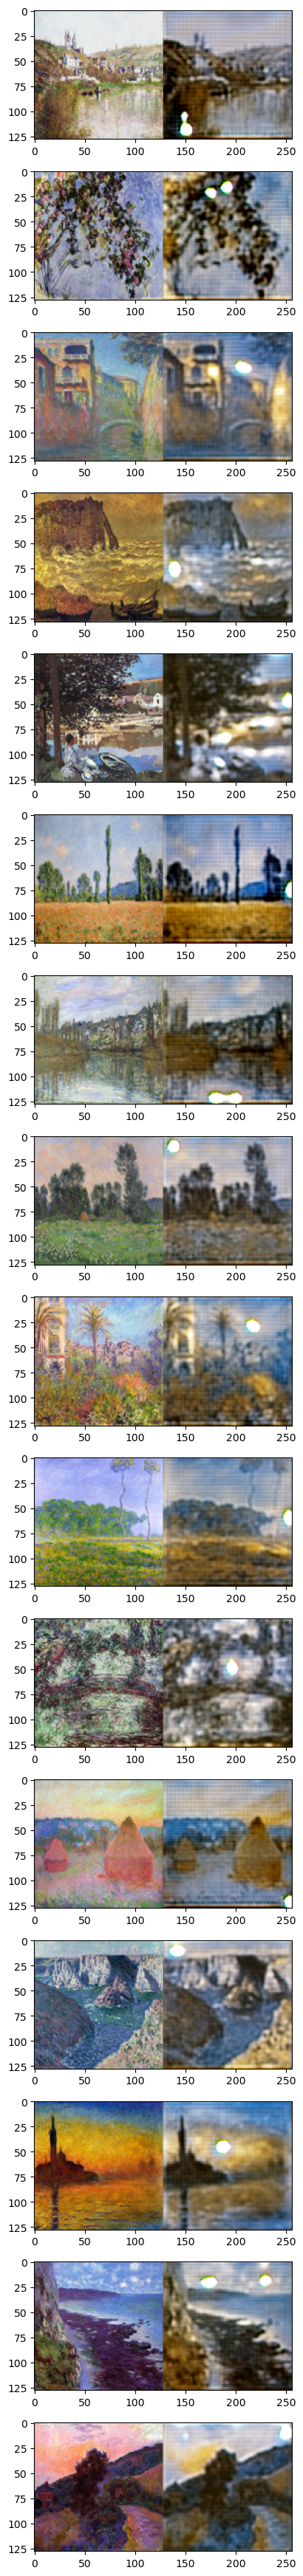

In [19]:
testA,testB = tf_data(image_dir+'test')
testA = testA.__iter__()
testB = testB.__iter__()

x_real_A, _ = generate_real(next(testA),16,0)
images_B,_ = generate_fake(x_real_A, genNew,16,0)

import matplotlib
fig,ax = plt.subplots(16,figsize=(35,35))
for index,img in enumerate(zip(x_real_A,images_B)):
    concat_numpy = np.clip(np.hstack((img[0],img[1])),0,1)
    ax[index].imshow(concat_numpy)
    #matplotlib.image.imsave(str(index)+'.png', concat_numpy)
    
fig.tight_layout()